# **Predicting Funding Rate Direction: Model Development**

## **Introduction**

In this notebook, we aim to develop predictive models to forecast the **direction of the funding rate movement** for Bitcoin perpetual futures contracts on Binance. The funding rate is a crucial metric in futures trading, reflecting the cost of holding positions and influencing traders' strategies. Accurately predicting its direction can provide significant advantages in trading decisions.

Our objectives are:

- **Data Preprocessing and Feature Engineering**: Clean and prepare the data, extract meaningful features, and handle any data-related challenges.
- **Model Training and Evaluation**: Train various machine learning models to predict the funding rate direction and evaluate their performance.
- **Model Improvement and Selection**: Enhance model performance through techniques like hyperparameter tuning and select the best-performing model.


In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd

# absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# project root directory to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import data processing functions
from utilities.data_processing import (
    load_data, 
    preprocess_data, 
    create_features, 
    process_pipeline
)

# Import feature engineering and data balancing utilities
from utilities.functions import (
    add_lag_features,
    add_technical_indicators,
    add_interaction_terms,
    # add_rate_of_change,
    # add_advanced_features
)

# Import model-related utilities
from utilities.model_utils import (
    train_classification_model,
    evaluate_classification_model,
    save_model,
    load_model,
    perform_hyperparameter_tuning,
    plot_feature_importance
)

# Import configurations
from config import (
    BINANCE_BTC_PERP_CSV,
    MODEL1_PATH,
    SCALER1_PATH,
    RANDOM_STATE
)

from sklearn.preprocessing import StandardScaler

## **Step 1: Data Preprocessing and Feature Engineering**

In this step, we prepare the data for modeling by performing preprocessing tasks and creating new features that may improve model performance.

### **1.1 Determining Funding Rate Direction**

We create the target variable `direction` to indicate whether the funding rate is expected to **increase (`1`)** or **decrease/remain the same (`0`)** in the next time period.

- **Methodology**:
  - Shift the `funding_rate` column by one period to get the future funding rate.
  - Compare the future funding rate with the current funding rate to determine the direction.
  - The `direction` is set to `1` if the future funding rate is higher; otherwise, it's `0`.

### **1.2 Feature Engineering**

To enhance the model's predictive power, we generate additional features:

- **Lag Features**:
  - `funding_rate_lag1`: Funding rate from the previous period.
  - `open_interest_lag1`: Open interest from the previous period.
  - `mark_price_lag1`: Mark price from the previous period.

- **Technical Indicators**:
  - `funding_rate_ma3`: 3-period moving average of the funding rate.

- **Cyclical Time Features**:
  - Convert time-based features (hour, day, month) into cyclical features using sine and cosine transformations to capture periodic patterns.

- **Data Handling**:
  - **Missing Values**: Filled `NaN` values resulting from lagging and moving averages using backward fill (`bfill`).
  - **Scaling**: Standardized numerical features to ensure they're on the same scale.

In [2]:
# Load and preprocess data
df = load_data(BINANCE_BTC_PERP_CSV)
df = preprocess_data(df)
df = create_features(df)

# Create the 'direction' target variable
df['future_funding_rate'] = df['funding_rate'].shift(-1)
df['direction'] = (df['future_funding_rate'] > df['funding_rate']).astype(int)
df.drop(columns=['future_funding_rate'], inplace=True)

# Add lag features
df = add_lag_features(df)

# Add technical indicators
df = add_technical_indicators(df)

# # Add advanced features
# df = add_advanced_features(df)

# Add interaction features
df = add_interaction_terms(df)

# Handle NaNs appropriately
df.bfill(inplace=True)

Data loaded. Preview:
          exchange   symbol  local_timestamp  funding_timestamp  funding_rate  \
0  binance-futures  BTCUSDT     1.577840e+15       1.577866e+15     -0.000161   
1  binance-futures  BTCUSDT     1.577844e+15       1.577866e+15     -0.000173   
2  binance-futures  BTCUSDT     1.577848e+15       1.577866e+15     -0.000183   
3  binance-futures  BTCUSDT     1.577851e+15       1.577866e+15     -0.000191   
4  binance-futures  BTCUSDT     1.577855e+15       1.577866e+15     -0.000187   

   predicted_funding_rate  open_interest  last_price  index_price  \
0                     NaN            NaN     7171.55          NaN   
1                     NaN            NaN     7208.32          NaN   
2                     NaN            NaN     7237.49          NaN   
3                     NaN            NaN     7221.55          NaN   
4                     NaN            NaN     7214.00          NaN   

    mark_price         timestamp  
0  7176.918847  1577836800000000  
1  721

## **Step 2: Model Training and Evaluation**

### **2.1 Random Forest Classifier**

#### **Description**

Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mode of the classes as the prediction.

#### **Implementation**

- **Handling Class Imbalance**: Used **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the classes in the training data.
- **Hyperparameter Tuning**: Employed `GridSearchCV` to find the optimal hyperparameters, such as the number of estimators and maximum depth.
- **Training**: Trained the Random Forest model with the best-found hyperparameters.

#### **Evaluation**

- **Metrics Used**: Same as logistic regression for consistency.
- **Results**:
  - Observed improvements in predictive performance over logistic regression.
  - Evaluated the model's ability to predict the minority class accurately.
  - Plotted feature importance to understand which features contributed most to the predictions.

Starting feature engineering...
Splitting the data...
Starting preprocessing for Random Forest...
Preprocessing for Random Forest completed in 0.00 seconds.
Training data shape for Random Forest: (33743, 15)
Test data shape for Random Forest: (8436, 15)
Training initial Random Forest model...
Random Forest training completed in 6.87 seconds.

Initial Model Evaluation:
Accuracy: 0.7579421526789948
F1 Score: 0.5121834687052079
ROC AUC Score: 0.8139223459835931
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      5879
           1       0.66      0.42      0.51      2557

    accuracy                           0.76      8436
   macro avg       0.72      0.66      0.68      8436
weighted avg       0.74      0.76      0.74      8436

Confusion Matrix:
 [[5322  557]
 [1485 1072]]
Starting hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 10, 'min_sampl

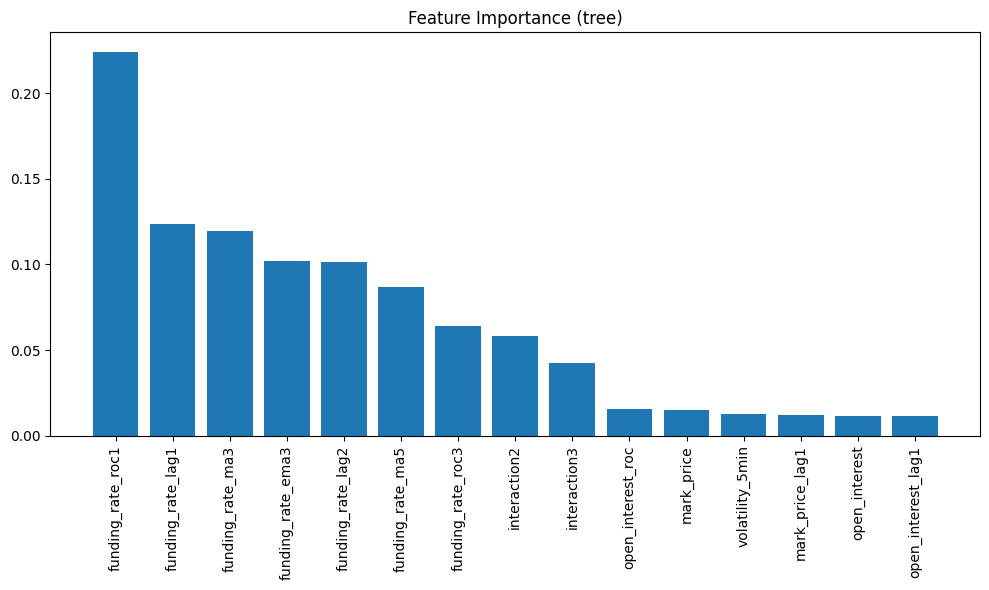

Saving the model and scaler...


In [4]:
from sklearn.ensemble import RandomForestClassifier

if not df.empty:
    try:
        print("Starting feature engineering...")

        # Feature Engineering
        df = add_lag_features(df)
        df = add_technical_indicators(df)
        df = add_interaction_terms(df)

        # Define features and target
        feature_columns = [
            'funding_rate_lag1', 'funding_rate_lag2',
            'funding_rate_ma3', 'funding_rate_ma5', 'funding_rate_ema3',
            'open_interest', 'open_interest_lag1', 'open_interest_roc',
            'mark_price', 'mark_price_lag1', 'volatility_5min',
            'funding_rate_roc1', 'funding_rate_roc3', 'interaction2', 'interaction3'
        ]

        X = df[feature_columns]
        y = df['direction']

        print("Splitting the data...")
        split_index = int(0.8 * len(X))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        if not X_train.empty and not X_test.empty:
            print("Starting preprocessing for Random Forest...")
            start_time = time.time()

            # Explicitly create copies to avoid SettingWithCopyWarning
            X_train_rf = X_train.copy()
            X_test_rf = X_test.copy()

            # Replace infinity values and handle NaNs explicitly for Random Forest
            X_train_rf.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_test_rf.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_train_rf.fillna(0, inplace=True)
            X_test_rf.fillna(0, inplace=True)

            print(f"Preprocessing for Random Forest completed in {time.time() - start_time:.2f} seconds.")
            print(f"Training data shape for Random Forest: {X_train_rf.shape}")
            print(f"Test data shape for Random Forest: {X_test_rf.shape}")

            # Train initial Random Forest model
            print("Training initial Random Forest model...")
            start_time = time.time()
            rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
            rf_model.fit(X_train_rf, y_train)
            print(f"Random Forest training completed in {time.time() - start_time:.2f} seconds.")

            print("\nInitial Model Evaluation:")
            evaluate_classification_model(rf_model, X_test_rf, y_test)

            # Start hyperparameter tuning
            print("Starting hyperparameter tuning...")
            start_time = time.time()
            param_grid = {
                'n_estimators': [50, 100],
                'max_depth': [10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
            best_rf_model = perform_hyperparameter_tuning(
                rf_model,
                param_grid,
                X_train_rf,
                y_train,
                scoring='roc_auc',
                verbose=1
            )
            print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds.")

            print("\nBest Model Evaluation After Hyperparameter Tuning:")
            evaluate_classification_model(best_rf_model, X_test_rf, y_test)

            # Evaluate with a custom threshold
            y_proba = best_rf_model.predict_proba(X_test_rf)[:, 1]
            custom_threshold = 0.5
            print(f"\nEvaluation with Custom Threshold ({custom_threshold}):")
            evaluate_classification_model(best_rf_model, X_test_rf, y_test, y_proba, threshold=custom_threshold)

            # Plot feature importance
            print("Plotting feature importance...")
            plot_feature_importance(best_rf_model, X_train_rf.columns)

            # Save the model and scaler
            print("Saving the model and scaler...")
            save_model(best_rf_model, '../models/saved_models/model1_RF.pkl')

    except Exception as e:
        print(f"Error during Random Forest training and tuning: {e}")

### **2.2 Logistic Regression**

#### **Description**

Logistic Regression is a linear model commonly used for binary classification problems. It models the probability that a given input belongs to a particular category.

#### **Implementation**

- **Handling Class Imbalance**: Addressed through techniques like class weighting or resampling (if applicable).
- **Feature Scaling**: Applied `StandardScaler` to numerical features to normalize the data.
- **Training**: Trained the logistic regression model using the processed training data.

#### **Evaluation**

- **Metrics Used**:
  - **Accuracy**: Overall correctness of the model.
  - **Precision**: Correct positive predictions out of all positive predictions.
  - **Recall**: Correct positive predictions out of all actual positives.
  - **ROC AUC Score**: Measure of the model's ability to distinguish between classes.

- **Results**:
  - Presented the classification report and confusion matrix.
  - Analyzed the model's performance, particularly on the minority class.

In [5]:
from sklearn.linear_model import LogisticRegression

if not os.path.exists(BINANCE_BTC_PERP_CSV):
    raise FileNotFoundError(f"Dataset not found at {BINANCE_BTC_PERP_CSV}")
else:
    print(f"Dataset found at {BINANCE_BTC_PERP_CSV}")

# Start pipeline execution
print("Starting pipeline execution...")
df = process_pipeline(BINANCE_BTC_PERP_CSV)

if df is None or df.empty:
    print("Dataset not processed properly. Check pipeline.")
    raise ValueError("Processed dataset is empty. Check the pipeline.")

print(f"Shape of DataFrame after processing: {df.shape}")
print(df.head())

# Splitting the data
print("Splitting the data...")
feature_columns = [
    'funding_rate_lag1', 'funding_rate_lag2',
    'funding_rate_ma5', 'funding_rate_ema3',
    'mark_price', 'mark_price_lag1',
    'funding_rate_ma3'
]

missing_columns = [col for col in feature_columns if col not in df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
    raise ValueError(f"The following required columns are missing: {missing_columns}")

X = df[feature_columns]
y = df['direction']

print(f"Feature columns: {feature_columns}")
print(f"Target variable: {y.name}")

split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Preprocessing
if not X_train.empty and not X_test.empty:
    print("Starting preprocessing...")
    start_time = time.time()

    # Use preprocess_data from data_processing.py
    X_train = preprocess_data(X_train, handle_timestamps=False)
    X_test = preprocess_data(X_test, handle_timestamps=False)

    numeric_features = [
        'funding_rate_lag1', 'funding_rate_lag2',
        'funding_rate_ma5', 'funding_rate_ema3',
        'mark_price', 'mark_price_lag1',
        'funding_rate_ma3'
    ]

    # Debug preview
    print("Preview of X_train before scaling:")
    print(X_train[numeric_features].head())

    # Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[numeric_features])
    X_test_scaled = scaler.transform(X_test[numeric_features])

    # Prepare processed data
    X_train_prepared = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
    X_test_prepared = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

    print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds.")
    print(f"Training data shape after preprocessing: {X_train_prepared.shape}")
    print(f"Test data shape after preprocessing: {X_test_prepared.shape}")

    # Train Logistic Regression model
    print("Training Logistic Regression model...")
    start_time = time.time()
    logreg_model = LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    )
    logreg_model.fit(X_train_prepared, y_train)
    print(f"Logistic Regression training completed in {time.time() - start_time:.2f} seconds.")

    # Evaluate initial model
    print("\nInitial Logistic Regression Model Evaluation:")
    evaluate_classification_model(logreg_model, X_test_prepared, y_test)

else:
    print("Training or test datasets are empty. Cannot proceed.")

Dataset found at c:\Users\viraj\BuildSpace\Projects\stat429_project\data\normalized_datasets\binance_btc_perp.csv
Starting pipeline execution...
Loading the dataset...
Data loaded. Preview:
          exchange   symbol  local_timestamp  funding_timestamp  funding_rate  \
0  binance-futures  BTCUSDT     1.577840e+15       1.577866e+15     -0.000161   
1  binance-futures  BTCUSDT     1.577844e+15       1.577866e+15     -0.000173   
2  binance-futures  BTCUSDT     1.577848e+15       1.577866e+15     -0.000183   
3  binance-futures  BTCUSDT     1.577851e+15       1.577866e+15     -0.000191   
4  binance-futures  BTCUSDT     1.577855e+15       1.577866e+15     -0.000187   

   predicted_funding_rate  open_interest  last_price  index_price  \
0                     NaN            NaN     7171.55          NaN   
1                     NaN            NaN     7208.32          NaN   
2                     NaN            NaN     7237.49          NaN   
3                     NaN            NaN     72

In [ ]:
filepath = BINANCE_BTC_PERP_CSV

# Ensure all steps execute
df = load_data(filepath)
print("Data loaded. Shape:", df.shape)
df = preprocess_data(df)
print("Data preprocessed. Shape:", df.shape)
df = add_lag_features(df)
print("Lag features added. Shape:", df.shape)
df = add_technical_indicators(df)
print("Technical indicators added. Shape:", df.shape)
df = add_interaction_terms(df)
print("Interaction terms added. Shape:", df.shape)
df = create_features(df)
print("Features and target created. Shape:", df.shape)


Data loaded. Preview:
          exchange   symbol  local_timestamp  funding_timestamp  funding_rate  \
0  binance-futures  BTCUSDT     1.577840e+15       1.577866e+15     -0.000161   
1  binance-futures  BTCUSDT     1.577844e+15       1.577866e+15     -0.000173   
2  binance-futures  BTCUSDT     1.577848e+15       1.577866e+15     -0.000183   
3  binance-futures  BTCUSDT     1.577851e+15       1.577866e+15     -0.000191   
4  binance-futures  BTCUSDT     1.577855e+15       1.577866e+15     -0.000187   

   predicted_funding_rate  open_interest  last_price  index_price  \
0                     NaN            NaN     7171.55          NaN   
1                     NaN            NaN     7208.32          NaN   
2                     NaN            NaN     7237.49          NaN   
3                     NaN            NaN     7221.55          NaN   
4                     NaN            NaN     7214.00          NaN   

    mark_price         timestamp  
0  7176.918847  1577836800000000  
1  721

### **2.3 Model Comparison**

- Compared the performance of logistic regression and Random Forest models.
- Discussed which model performed better and why.
- Considered factors like overfitting, computational efficiency, and interpretability.